# record known nodes
We will record specific job ids to txt files for sets of jobs with known health values. This is somewhat arbitrary, and human driven.

We will record bad jobs, good jobs, and excellent jobs. We will use sets of 5.

In [3]:
# import  epmt query 
print('importing epmt_query')
import epmt_query as eq
# import matplot for better plotting functions
import sys
sys.path.insert(0,'/home/Avery.Kiihne/pip_experiment')
import matplotlib.pyplot as plt
import numpy as np
# import pandas. optional but helpful 'display.max_columns' arg shows all DataFrame columns when printing
print('importing pandas')
import pandas
pandas.set_option('display.max_columns', None)
import pickle

importing epmt_query
importing pandas


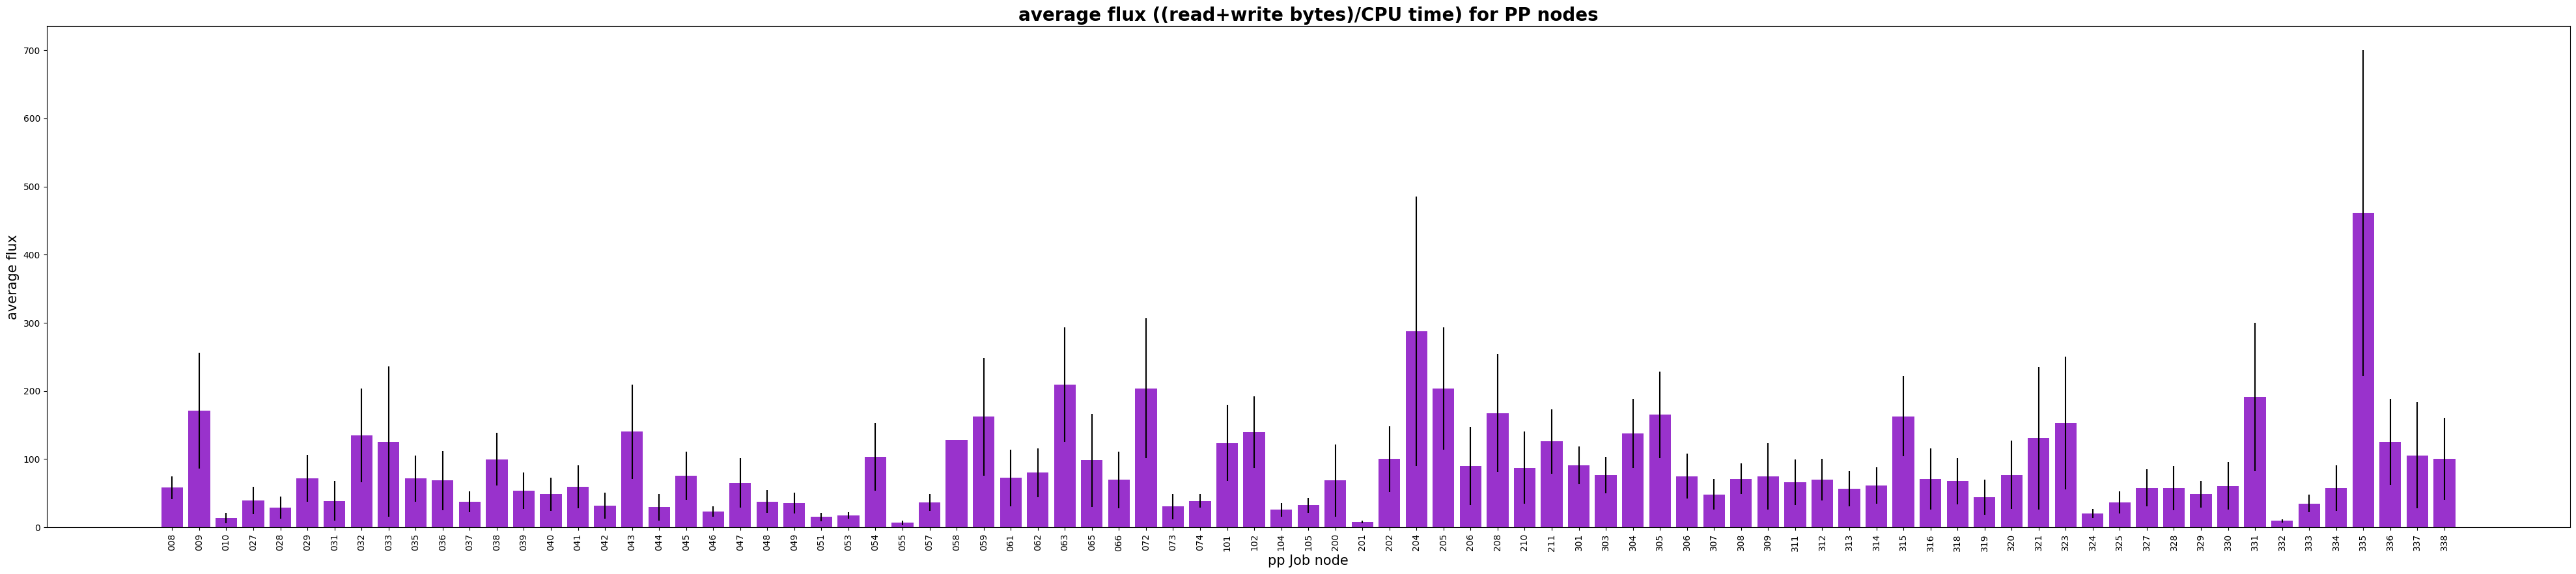

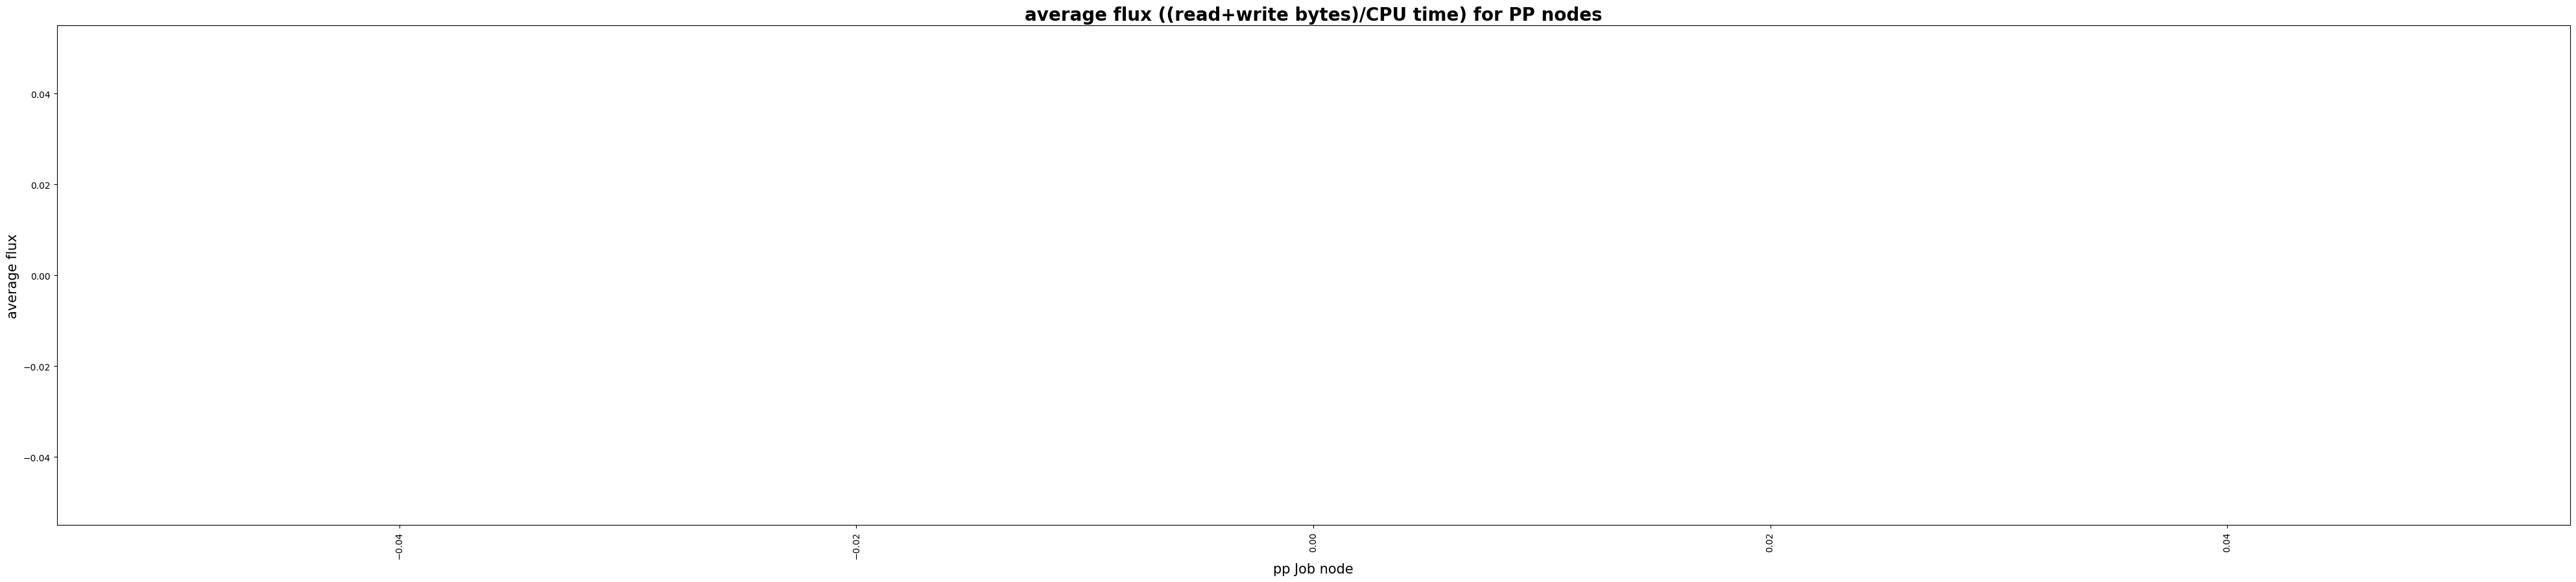

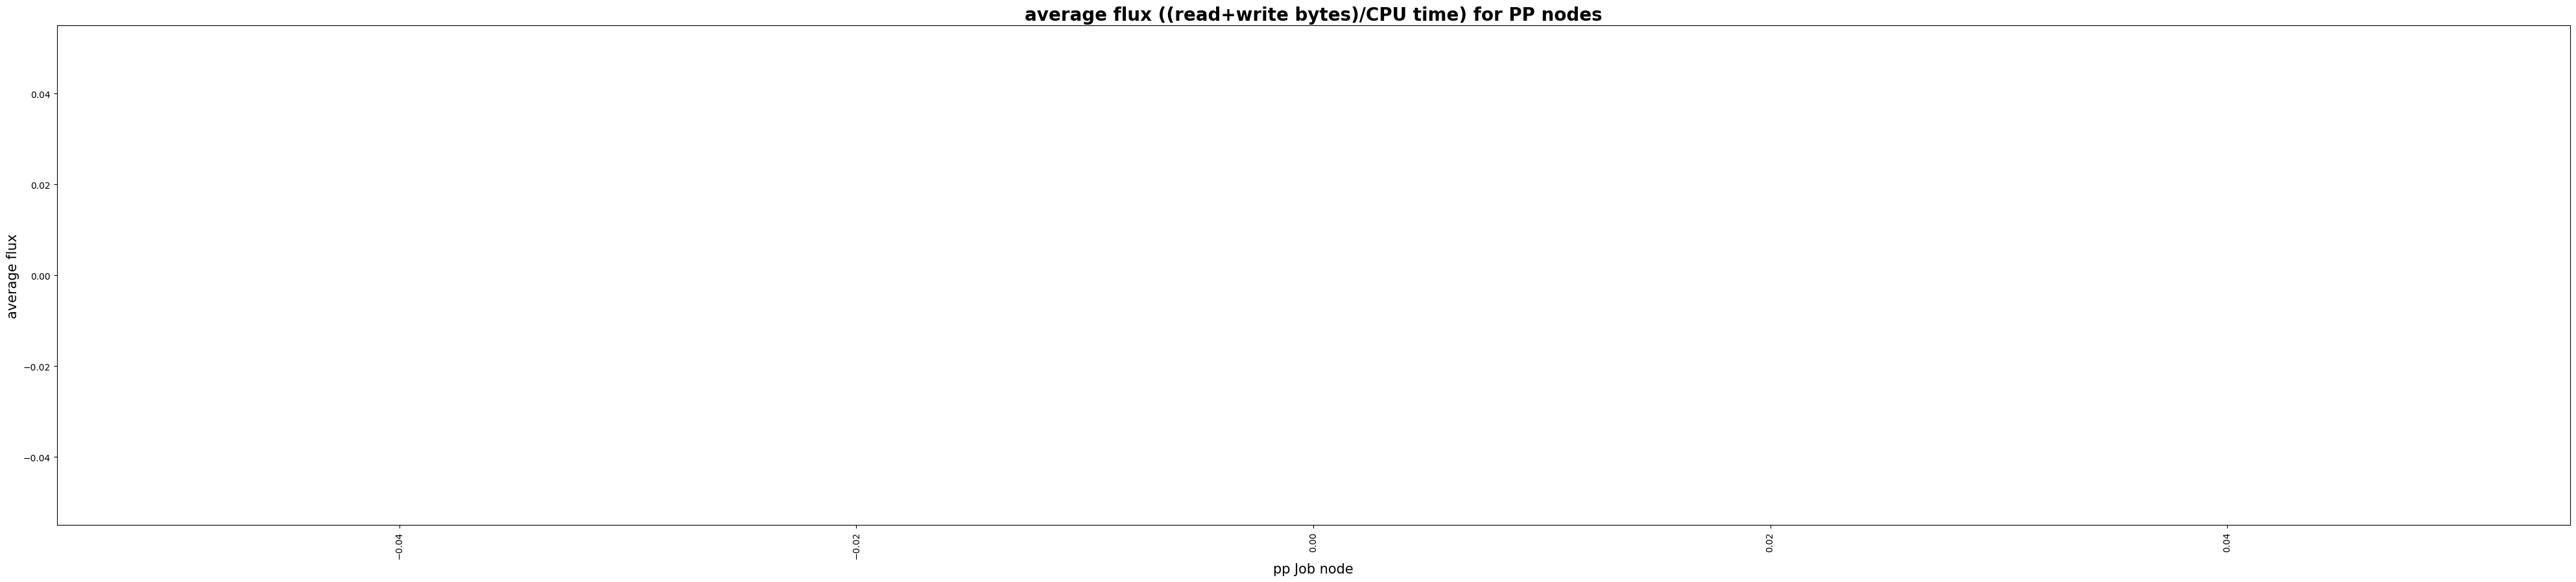

In [5]:
#massive loop to view multiple weeks back to back really easily
for aa in range(3):
    jobs_all = eq.get_jobs(limit = 1000, before = -(1+7*aa), after = -(8+7*aa), fmt = 'dict')
    
    #pull data from jobs and store in dictionaries
    #make list of unique nodes
    node_list = [] 
    for jobs_instance in range(len(jobs_all)):
        node_list.append(jobs_all[jobs_instance]['env_dict']['SLURM_NODELIST'])
    node_list = sorted(set(node_list))
    #make dictionary with each unique name as a key
    CPU_runtime_dict = {}
    wr_bytes_dict = {}
    rd_bytes_dict = {}
    flux_avg_dict = {}
    #each tag group has its own key in variable dictonary
    for dict_key in node_list:   
        CPU_runtime_dict[dict_key] = []
        wr_bytes_dict[dict_key] = []
        rd_bytes_dict[dict_key] = []
        flux_avg_dict[dict_key] = []
    #now we can run through evry job and grab its specific stats to attach to its node
    for jobs_instance in range(len(jobs_all)):   
        dict_key_instance = jobs_all[jobs_instance]['env_dict']['SLURM_NODELIST']
        if jobs_all[jobs_instance].get('read_bytes') is not None:
            if jobs_all[jobs_instance]['read_bytes'] + jobs_all[jobs_instance]['write_bytes'] > 0:   #if statements to adress problem cases
                CPU_runtime_dict[dict_key_instance].append(jobs_all[jobs_instance]['cpu_time'])
                wr_bytes_dict[dict_key_instance].append(jobs_all[jobs_instance]['write_bytes'])
                rd_bytes_dict[dict_key_instance].append(jobs_all[jobs_instance]['read_bytes'])
                flux_avg_dict[dict_key_instance].append((jobs_all[jobs_instance]['write_bytes']+jobs_all[jobs_instance]['read_bytes'])/jobs_all[jobs_instance]['cpu_time'])
    #calculations portion
    #we sepaflux nodes by type, as an nodes do different things than pp nodes
    flux_avg = []
    flux_avg_an = []
    flux_avg_pp = []
    flux_err_an = []
    flux_err_pp = []
    flux_error = []
    pp_nodes = []
    an_nodes = []
    for node in node_list:
        if node.find('an') > -1:
            an_nodes.append(node)
        else:
            pp_nodes.append(node)
    #average and error calculations for each node
    for node_name in node_list:
        if node_name in pp_nodes:
            flux_avg_pp.append(sum(flux_avg_dict[node_name])/len(flux_avg_dict[node_name]))
            flux_err_pp.append(np.std(flux_avg_dict[node_name])/(len(flux_avg_dict[node_name]))**.5)
        else:
            flux_avg_an.append(sum(flux_avg_dict[node_name])/len(flux_avg_dict[node_name]))
            flux_err_an.append(np.std(flux_avg_dict[node_name])/(len(flux_avg_dict[node_name]))**.5)
    #Plot creation for rssmax of nodes
    pp_nodes_short = []   #shorten node name by removing letters. this makes plot slighly cleaer
    for aa in range(len(pp_nodes)):
        pp_nodes_short.append(pp_nodes[aa][2:5])
    plt.style.use('default')
    plt.figure(figsize = (50, 10))
    plt.bar(pp_nodes_short,flux_avg_pp, yerr = flux_err_pp, label = 'flux', color = 'darkorchid')
    #bells n whistles
    plt.title('average flux ((read+write bytes)/CPU time) for PP nodes', fontweight ='bold', fontsize = 20)
    plt.ylabel('average flux', fontsize = 15)
    plt.xlabel('pp Job node', fontsize = 15)
    plt.xticks( rotation=90)
    #cleanup
    plt.tight_layout
    plt.show()

In [167]:
#record good nodes. these nodes are a baseline, average performance
good_jobs = []
node_group = ['pp038'] #nodes with good standing
loops = 4 #number of sets grabbed. there is a gap between each set.
f = open("good_node_ids.txt", "w")   #start by clearing file, then appending #use 'w' if overwritting, instead of 'a' for appending
f.close()
for node_name in node_group:
    for aa in range(loops):
        good_jobs.append(eq.get_jobs(limit = 5, before = -7, hosts = [node_name] , offset = 10*aa)) #grab 5 jobs, skip next 5, grab 5 again
for job_set in good_jobs:
    good_ids = []
    for job in job_set:
        good_ids.append(int(job['jobid']))
    good_dictionary = repr(good_ids)
    f = open("good_node_ids.txt", "a")   #use 'w' if overwritting, instead of 'a' for appending
    f.write(good_dictionary + '\n')
    f.close()

In [186]:
#how to retrieve data once it is stored
f = open("good_node_ids.txt")   #use 'w' if overwritting, instead of 'a' for appending
newlist = [i for i in f]
id_list = []
for ii in range(len(newlist)):
    string1 = newlist[ii].split("[")[1]
    string2 = string1.split("]")[0]
    string3 = string2.replace(' ','')
    string4 = string3.split(",")
    id_list.extend(string4)
j= eq.get_jobs(jobs = id_list)